# LASSO回归分析

## $\S1$ Configuration & Data Preparation

In [ ]:
# Configuration
## Loading Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score


## Data Path
Path = "./Raw_Data_5.xlsx"
Dependent_Variable = "USD_index_Close"

## Param Grid
param_grid = {
    "model__alpha": np.logspace(-3, 3, 100)
}

## CV Scoring
scoring = {
    ### sklearn默认maximize the score, so we use prefix "neg"
    "RMSE": "neg_root_mean_squared_error",
    "MAE": "neg_mean_absolute_error",
    "R2": "r2"
}


In [40]:
# Data Preparation
## Loading Data
Data = pd.read_excel(Path, index_col="日期")
print("Data Size:", Data.shape)

## Data Split & Scale
### Split Features and Label
X = Data.drop(columns=[Dependent_Variable])
y = Data[[Dependent_Variable]]
# X,y = X.values, y.values

Data Size: (3209, 36)


In [41]:
### Split Train, Valid and Test Sets
train_size = int(len(Data) * 0.8)
X_train, X_test = X.iloc[:train_size, :], X.iloc[train_size:, :]
y_train, y_test = y.iloc[:train_size, :], y.iloc[train_size:, :]

#### Split Train Set into Tims Series
tsCV = TimeSeriesSplit(n_splits=5)
for fold, (train_idx, test_idx) in enumerate(tsCV.split(X_train)):
    print(f"Fold {fold}: Train {len(train_idx)}, Test {len(test_idx)}")


Fold 0: Train 432, Test 427
Fold 1: Train 859, Test 427
Fold 2: Train 1286, Test 427
Fold 3: Train 1713, Test 427
Fold 4: Train 2140, Test 427


## $\S2$ Model Training & Predicting

In [ ]:
## Generating Pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Lasso(random_state=42)),
]
)

## Model Selection
### Grid_Search with Pipe on Grid using TimeSeriesSplit CV on Train Set
gsCV = GridSearchCV(
    estimator = pipe,
    param_grid=param_grid,
    cv = tsCV,
    scoring = scoring,
    refit = "R2",
    n_jobs = -1,
    verbose = 2
)
gsCV.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,{'model__alpha': array([1.0000...00000000e+03])}
,scoring,"{'MAE': 'neg_mean_absolute_error', 'R2': 'r2', 'RMSE': 'neg_root_mean_squared_error'}"
,n_jobs,-1
,refit,'R2'
,cv,TimeSeriesSpl...est_size=None)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [43]:
### printing best model
#### Best Hyper Parameters:
print("Grid Search 最佳参数: ", gsCV.best_params_)
print("对应的(CV平均)最优R2:", gsCV.best_score_)

#### CV Results:
result = pd.DataFrame(gsCV.cv_results_)
cols_to_show = ["param_model__alpha", "mean_test_RMSE", "mean_test_MAE", "mean_test_R2"]
result["mean_test_MAE"] = -result["mean_test_MAE"]
result["mean_test_RMSE"] = -result["mean_test_RMSE"]
print(result[cols_to_show].sort_values(by="mean_test_R2", ascending=False).head(10))

Grid Search 最佳参数:  {'model__alpha': np.float64(1000.0)}
对应的(CV平均)最优R2: -0.006004003361100097
    param_model__alpha  mean_test_RMSE  mean_test_MAE  mean_test_R2
99         1000.000000        0.005102       0.003897     -0.006004
98          869.749003        0.005107       0.003903     -0.008556
97          756.463328        0.005112       0.003909     -0.011368
96          657.933225        0.005118       0.003915     -0.014421
95          572.236766        0.005124       0.003922     -0.017687
94          497.702356        0.005131       0.003928     -0.021136
93          432.876128        0.005138       0.003935     -0.024737
92          376.493581        0.005145       0.003943     -0.028454
91          327.454916        0.005153       0.003951     -0.032252
90          284.803587        0.005161       0.003959     -0.036097


In [44]:
## Model Prediction
### 在gsCV中，refit已经选取了最优模型，Pipe在整个训练集上进行了重新训练
best_lasso = gsCV.best_estimator_
best_lasso.named_steps["model"].alpha
y_pred = best_lasso.predict(X_test)

Text(0.5, 1.0, 'LASSO Regression Prediction')

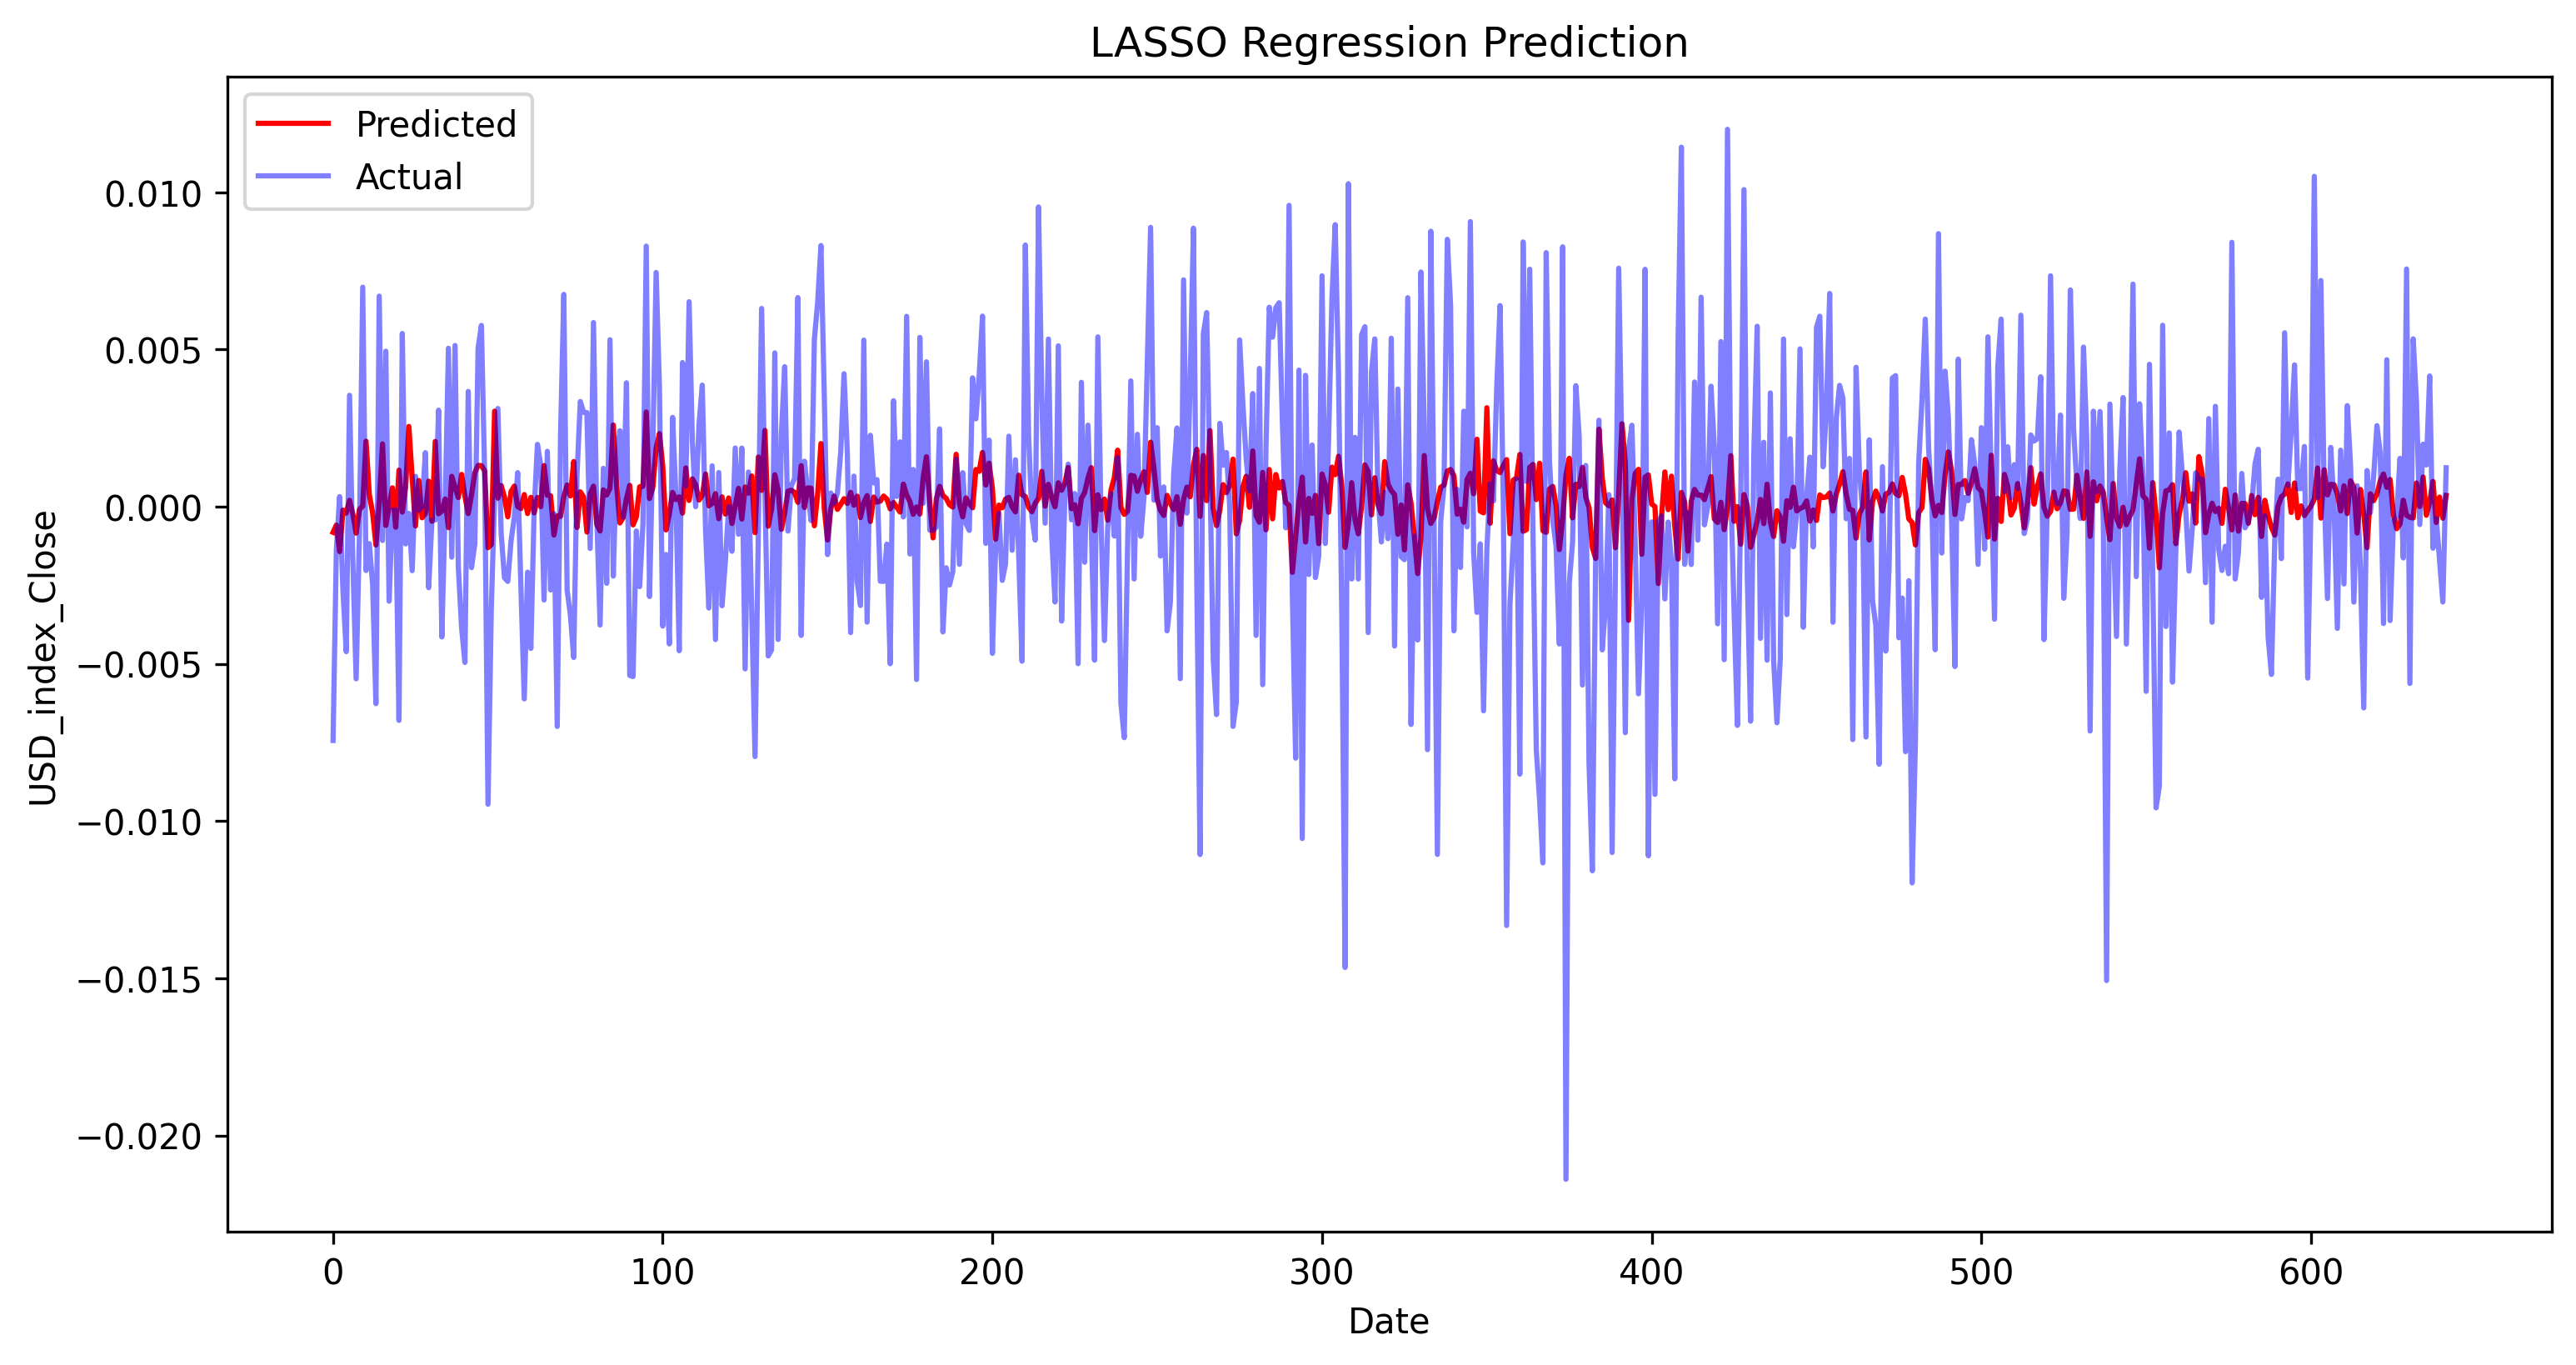

In [45]:
### Prediction Visualization
fig, ax1 = plt.subplots(figsize=(12,6), dpi=300)
ax1.plot(y_pred, label="Predicted", color="red")
ax1.plot(y_test.values, label="Actual", color="blue", alpha=0.5)
ax1.set_xlabel("Date")
ax1.set_ylabel("USD_index_Close")
ax1.legend()
ax1.set_title("LASSO Regression Prediction")

## $\S3$ Model Evaluation & Explanation

In [46]:
## Model Evaluation
# 4.2 计算测试集指标
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = root_mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print("=== 测试集表现 ===")
print(f"MAE  : {test_mae:.6f}")
print(f"RMSE  : {test_rmse:.6f}")
print(f"R^2  : {test_r2:.6f}")

=== 测试集表现 ===
MAE  : 0.003270
RMSE  : 0.004272
R^2  : 0.012233


In [47]:
best_lasso.named_steps["model"].coef_

array([ 2.91332775e-05,  4.96914237e-04,  4.09576007e-05, -3.77230671e-05,
       -3.16740692e-04, -5.43213426e-05,  9.70902184e-06,  5.67502766e-05,
        1.76649756e-05,  5.71455130e-05, -2.93368694e-05,  1.20549883e-04,
       -2.30666059e-04, -1.60095248e-04,  8.77418365e-05, -1.66114253e-04,
       -9.97112201e-05, -1.65287025e-05,  6.35704458e-05, -2.22961453e-05,
       -4.22495446e-05,  4.96215692e-05,  1.34258471e-06, -1.49153662e-05,
       -2.09375179e-04, -8.86235443e-05, -1.47335052e-05,  2.14380174e-04,
       -1.02366746e-04, -7.03041654e-05, -5.71104370e-05, -2.14279089e-06,
       -2.97069782e-05,  6.41853718e-05,  5.10044124e-05])